## 1. Introduction

The goal of this project is to build and evaluate a binary classification model that predicts customer churn for a newspaper subscription service. Logistic Regression was selected as the classification model. The analysis follows a complete machine learning pipeline including data preprocessing, feature engineering, model training, hyperparameter tuning, and final evaluation.


In [2]:
#%pip install liac-arff
import numpy as np
import pandas as pd
import arff

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    RocCurveDisplay, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

In [3]:
with open("dataset_", "r", encoding="utf-8", errors="ignore") as f:
    data = arff.load(f)

df = pd.DataFrame(
    data["data"],
    columns=[a[0] for a in data["attributes"]]
)

## 2. Initial Analysis and Data Cleaning

In this step, the dataset was explored to understand its structure, data types, and the presence of missing values. Identifier-like and non-informative columns were removed. The target variable was transformed into a binary numerical format. No imputation was performed at this stage to avoid data leakage.


In [8]:
df.head()

,SubscriptionID,HH Income,Home Ownership,Ethnicity,dummy for Children,Year Of Residence,Age range,Language,Address,State,City,County,Zip Code,weekly fee,Deliveryperiod,Nielsen Prizm,reward program,Source Channel,Subscriber
0,180590686,"$ 30,000 - $39,999",RENTER,German,N,1,25-29,German,1 3RD PL UNIT 703,CA,LONG BEACH,LOS ANGELES,90802,$7.00 - $7.99,7Day,FM,0,CircAdm,NO
1,181401653,"$500,000 Plus",OWNER,unknown,Y,14,50-54,None,1 AVIGNON,CA,NEWPORT COAST,ORANGE,92657,$0.01 - $0.50,SunOnly,MW,0,Partner,YES
2,180374685,"$100,000 - $124,999",OWNER,Italian,Y,7,45-49,English,1 BLACKSWAN,CA,IRVINE,ORANGE,92604,$0.01 - $0.50,SunOnly,MW,0,Partner,YES
3,180703483,"$200,000 - $249,999",OWNER,English,N,23,55-59,English,1 BLUE HORIZON,CA,LAGUNA NIGUEL,ORANGE,92677,$1.00 - $1.99,SunOnly,MW,1,Internet,NO
4,180358906,"$ 50,000 - $59,999",OWNER,Italian,N,23,60-64,English,1 BRISA DEL LAGO,CA,RANCHO SANTA MARGARITA,ORANGE,92688,$8.00 - $8.99,Thu-Sun,MM,0,Crew,YES


In [13]:
df.shape

(15855, 19)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SubscriptionID      15855 non-null  int64 
 1   HH Income           15855 non-null  object
 2   Home Ownership      15855 non-null  object
 3   Ethnicity           15855 non-null  object
 4   dummy for Children  15855 non-null  object
 5   Year Of Residence   15855 non-null  int64 
 6   Age range           15747 non-null  object
 7   Language            14848 non-null  object
 8   Address             15855 non-null  object
 9   State               15855 non-null  object
 10  City                15855 non-null  object
 11  County              15855 non-null  object
 12  Zip Code            15855 non-null  int64 
 13  weekly fee          15669 non-null  object
 14  Deliveryperiod      15855 non-null  object
 15  Nielsen Prizm       15726 non-null  object
 16  reward program      15

In [10]:
df.describe(include="all")

,SubscriptionID,HH Income,Home Ownership,Ethnicity,dummy for Children,Year Of Residence,Age range,Language,Address,State,City,County,Zip Code,weekly fee,Deliveryperiod,Nielsen Prizm,reward program,Source Channel,Subscriber
count,1.585500e+04,15855,15855,15855,15855,15855.000000,15747,14848,15855,15855,15855,15855,15855.000000,15669,15855,15726,15855.000000,15855,15855
unique,NaN,18,2,73,2,NaN,12,37,15742,1,56,4,NaN,14,28,9,NaN,51,2
top,NaN,"Under $20,000",OWNER,Hispanic,N,NaN,50-54,English,1021 W BISHOP ST APT A,CA,ANAHEIM,ORANGE,NaN,$0.01 - $0.50,SunOnly,MW,NaN,Partner,NO
freq,NaN,1917,11690,4087,12397,NaN,1913,11005,3,15855,1567,14351,NaN,2950,6186,4040,NaN,4387,12818
mean,1.643729e+08,NaN,NaN,NaN,NaN,13.546137,NaN,NaN,NaN,NaN,NaN,NaN,92424.541911,NaN,NaN,NaN,1.100662,NaN,NaN
std,2.356755e+07,NaN,NaN,NaN,NaN,11.770368,NaN,NaN,NaN,NaN,NaN,NaN,733.648427,NaN,NaN,NaN,9.555332,NaN,NaN
min,1.100011e+08,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,90603.000000,NaN,NaN,NaN,0.000000,NaN,NaN
25%,1.501824e+08,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,92627.000000,NaN,NaN,NaN,0.000000,NaN,NaN
50%,1.803333e+08,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,92688.000000,NaN,NaN,NaN,0.000000,NaN,NaN
75%,1.806362e+08,NaN,NaN,NaN,NaN,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,92806.000000,NaN,NaN,NaN,0.000000,NaN,NaN


In [11]:
df["Subscriber"].value_counts()


Subscriber
NO     12818
YES     3037
Name: count, dtype: int64

### Key Observations

- **Dataset Structure:** The dataset consists of 15,855 observations and 19 features, combining numerical variables (e.g. *Year Of Residence*, *reward program*) with a large number of categorical attributes.
- **Missing Data:** Missing values are present in several categorical columns, including *Age range*, *Language*, and *Nielsen Prizm*. These gaps will be addressed during preprocessing using imputation within the modeling pipeline.
- **Low-Variance Feature:** The *State* variable contains only a single value (`CA`) for all observations and therefore does not contribute meaningful information for classification.
- **High-Cardinality Variables:** Columns such as *Address*, *City*, and *Zip Code* exhibit very high cardinality, which may introduce noise and unnecessary dimensionality if encoded directly.
- **Target Distribution:** The target variable *Subscriber* is imbalanced, with non-subscribers forming the majority class. This motivates the use of class-balanced modeling and evaluation metrics beyond accuracy.
- **Skewed Numerical Feature:** The *reward program* variable shows a highly skewed distribution, suggesting that a small number of customers use a disproportionately large number of rewards.
- **Identifier Feature:** *SubscriptionID* is a unique identifier and does not contain predictive information; therefore, it will be removed prior to model training.

These observations guided the feature selection, preprocessing strategy, and model configuration used in subsequent stages of the analysis.


In [4]:
df["Churn"] = df["Subscriber"].map({
    "YES": 0,
    "NO": 1
})

In [5]:
df["Churn"].value_counts(normalize=True)

Churn
1    0.808452
0    0.191548
Name: proportion, dtype: float64

State was dropped due to zero variance (only 'CA'). Address, City and Zip Code were dropped because they are high-cardinality location identifiers that would greatly increase dimensionality after encoding and may introduce noise.

In [6]:
df = df.drop(columns=["SubscriptionID", "Address", "Zip Code", "State", "City"], errors="ignore")

In [7]:
df.isna().sum().sort_values(ascending=False)

Language              1007
weekly fee             186
Nielsen Prizm          129
Age range              108
HH Income                0
Home Ownership           0
Ethnicity                0
dummy for Children       0
Year Of Residence        0
County                   0
Deliveryperiod           0
reward program           0
Source Channel           0
Subscriber               0
Churn                    0
dtype: int64

## 3. Feature Engineering

The Nielsen Prizm variable was decomposed into two features representing
customer life stage and maturity level to improve interpretability and
compatibility with Logistic Regression.


In [8]:
def life_stage(prizm):
    if pd.isna(prizm):
        return "Unknown"
    prizm = prizm.upper()
    if prizm.startswith("Y"):
        return "Younger"
    if prizm.startswith("F"):
        return "Family"
    if prizm.startswith("M"):
        return "Mature"
    return "Unknown"

def maturity_level(prizm):
    if pd.isna(prizm):
        return np.nan
    prizm = prizm.upper()
    if prizm.endswith("E"):
        return 0
    if prizm.endswith("M"):
        return 1
    if prizm.endswith("W"):
        return 2
    return np.nan

df["Life_Stage"] = df["Nielsen Prizm"].apply(life_stage)
df["Maturity_Level"] = df["Nielsen Prizm"].apply(maturity_level)
df = df.drop(columns=["Nielsen Prizm"])

The target variable ('y') is the binary churn label, while 'X' contains the remaining predictor features. The data was split into training and test sets (80/20). Stratified splitting was used to preserve the class distribution due to class imbalance.

In [9]:
y = df["Churn"]
X = df.drop(columns=["Churn", "Subscriber"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [11]:
print("Train churn rate:", y_train.mean())
print("Test churn rate:", y_test.mean())

Train churn rate: 0.8084200567644276
Test churn rate: 0.8085777357300536


## 4. Model Training and Optimization

All preprocessing steps (imputation of missing values, scaling, and encoding) are performed inside a single pipeline to prevent data leakage. Hyperparameters of Logistic Regression were tuned using stratified cross-validation with F1-score as the primary metric due to class imbalance.

In [12]:
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['Year Of Residence', 'reward program', 'Maturity_Level']
Categorical: ['HH Income', 'Home Ownership', 'Ethnicity', 'dummy for Children', 'Age range', 'Language', 'County', 'weekly fee', 'Deliveryperiod', 'Source Channel', 'Life_Stage']


In [13]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

In [14]:
clf = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    random_state=42
)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", clf)
])

In [15]:
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 50],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV F1:", grid.best_score_)
best_model = grid.best_estimator_

Best parameters: {'classifier__C': 50, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best CV F1: 0.8333469413916411


## 5. Final Evaluation

The final model was evaluated on a held-out test set that was not used during training or hyperparameter tuning. Model performance was assessed using accuracy, F1-score, and ROC-AUC to provide a balanced evaluation in the presence of class imbalance.

In [16]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.7634815515610217
F1-score: 0.8404255319148937
ROC-AUC: 0.8449157900418159

Classification report:
               precision    recall  f1-score   support

           0     0.4309    0.7348    0.5432       607
           1     0.9246    0.7703    0.8404      2564

    accuracy                         0.7635      3171
   macro avg     0.6778    0.7525    0.6918      3171
weighted avg     0.8301    0.7635    0.7835      3171



The results indicate that the Logistic Regression model is able to distinguish between churned and retained customers better than random guessing, as reflected by the ROC-AUC score. Due to class imbalance, accuracy alone is less informative, while the F1-score provides a more balanced view of model performance. Overall, the model demonstrates reasonable discriminatory power given the simplicity and interpretability of the chosen approach.

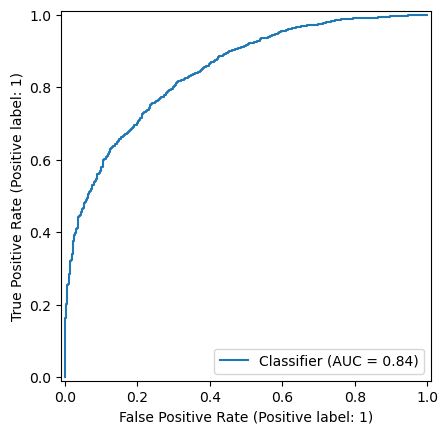

In [17]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

The ROC curve illustrates the trade-off between the true positive rate and false positive rate across different classification thresholds. The ROC-AUC score (0.84) indicates good discriminative ability between churned and retained customers.

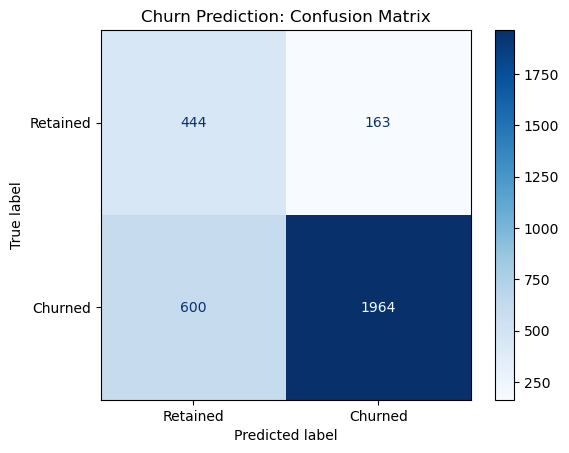

In [57]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Retained", "Churned"],
    cmap="Blues"
)
plt.title("Churn Prediction: Confusion Matrix")
plt.show()

The confusion matrix provides a detailed view of the model’s predictions at the default classification threshold, highlighting the trade-off between correctly identifying churned customers and avoiding false positives. This representation complements the ROC curve by showing performance at a specific operating point.

## Conclusion

Overall, the applied preprocessing strategy and feature engineering enabled a robust and interpretable Logistic Regression model for customer churn prediction.